In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.utils import shuffle
import mogptk

from waflgp import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


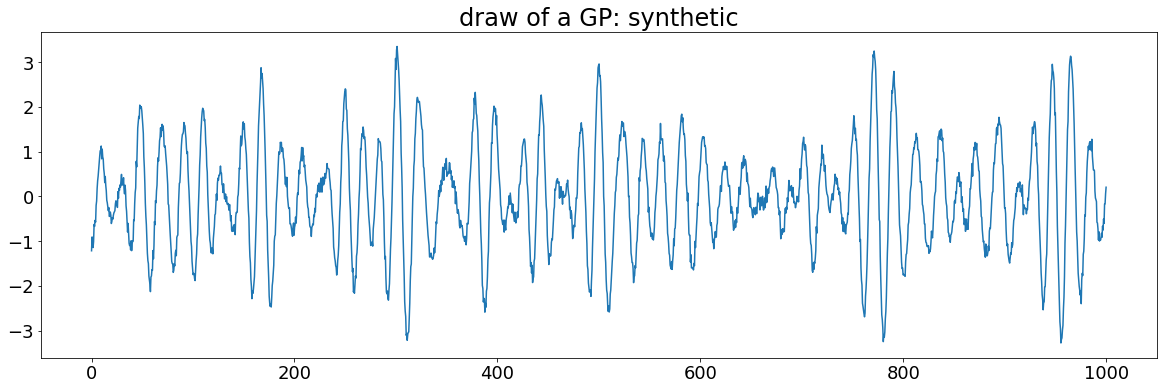

In [53]:
# generate
# synthetic data (GP sample with SM kernel)

t0 = 0
tf = 1000
Nobs = 2000
times = np.linspace(t0,tf,Nobs)
gp = waflgp(space_input=times, aim = 'sampling', kernel = 'SM')
gp.sigma_n = 0.1
l_freq = 0.01
g_freq = 1/(2*l_freq**2)
gp.gamma = np.pi**2/g_freq
mu_freq = 0.05 #0.00001 #
gp.mu = mu_freq

log_theta_init = (np.log(gp.gamma), np.log(gp.mu), np.log(gp.sigma), np.log(gp.sigma_n))
    
        
#sample
values = gp.sample(times)
gp.time_label = 'time'
gp.signal_label = 'synthetic'
plt.figure(figsize=(20,6))
plt.plot(times, values)
plt.title(f'draw of a GP: {gp.signal_label}');

In [127]:
times_shuffled, values_shuffled = shuffle(times, values, random_state=0)
step = 25
indices = np.arange(200, 2000+step, step)

time_stamps = np.zeros((3,len(indices)))
loc = np.zeros((3,len(indices)))
scale = np.zeros((3,len(indices)))
nll = np.zeros((3,len(indices)))

Q = 1
lr = 0.2
iterations = 1000

magnitude = np.random.randn(Q)
mean = np.random.randn(Q, 1)
variance = np.random.randn(Q, 1)

mogptk.gpr.use_cpu()

for i, Nobs in enumerate(indices):
    print(f'iteration for {Nobs} datapoints')
    times_train, values_train = times_shuffled[:Nobs], values_shuffled[:Nobs]
    
    #WAFL
    gp = waflgp(space_input=times_train,  space_output=values_train, aim = 'learning', kernel = 'SE')
    gp.real_world = True
    t0 = time.time()
    gp.train_WL()
    time_stamps[0,i] = time.time() - t0
    loc[0,i] = gp.theta[0]
    scale[0,i] = gp.theta[1]  
    
    #MOGP
    data = mogptk.Data(times_train, values_train, name='synth')
    if Nobs <= 2000:
        model = mogptk.SM(data, Q=Q)
        for q in range(Q):
            model.gpr.kernel[0][q].magnitude.assign(magnitude[q])
            model.gpr.kernel[0][q].mean.assign(mean[q])
            model.gpr.kernel[0][q].variance.assign(variance[q])   

        t0 = time.time()
        model.train('LBFGS', iters=iterations, lr=lr)
        time_stamps[1,i] = time.time() - t0
        loc[1,i] = model.gpr.kernel[0][0].mean.numpy()
        scale[1,i] = model.gpr.kernel[0][0].variance.numpy() 
        nll[1,i] = model.losses[-1]   
    
    #MOGP sparse
    inference = mogptk.Titsias(inducing_points=200)
    model = mogptk.SM(data, inference=inference, Q=Q)
    for q in range(Q):
        model.gpr.kernel[0][q].magnitude.assign(magnitude[q])
        model.gpr.kernel[0][q].mean.assign(mean[q])
        model.gpr.kernel[0][q].variance.assign(variance[q]) 
    
    t0 = time.time()
    model.train('LBFGS', iters=iterations, lr=lr)
    time_stamps[2,i] = time.time() - t0
    loc[2,i] = model.gpr.kernel[0][0].mean.numpy()
    scale[2,i] = model.gpr.kernel[0][0].variance.numpy()
    nll[2,i] = model.losses[-1]

np.savetxt("exp4/indices.csv", indices)
np.savetxt("exp4/time_stamps.csv", time_stamps)
np.savetxt("exp4/loc.csv", loc)
np.savetxt("exp4/scale.csv", scale)
np.savetxt("exp4/nll.csv", nll)

iteration for 200 datapoints
iteration for 225 datapoints
iteration for 250 datapoints
iteration for 275 datapoints
iteration for 300 datapoints
iteration for 325 datapoints
iteration for 350 datapoints
iteration for 375 datapoints
iteration for 400 datapoints
iteration for 425 datapoints
iteration for 450 datapoints
iteration for 475 datapoints
iteration for 500 datapoints
iteration for 525 datapoints
iteration for 550 datapoints
iteration for 575 datapoints
iteration for 600 datapoints
iteration for 625 datapoints
iteration for 700 datapoints
iteration for 725 datapoints
iteration for 750 datapoints
iteration for 775 datapoints
iteration for 800 datapoints
iteration for 825 datapoints
iteration for 850 datapoints
iteration for 875 datapoints
iteration for 900 datapoints
iteration for 925 datapoints
iteration for 950 datapoints
iteration for 975 datapoints
iteration for 1000 datapoints
iteration for 1025 datapoints
iteration for 1050 datapoints
iteration for 1075 datapoints
iteration 

In [4]:
indices = np.loadtxt("exp4/indices.csv")
time_stamps = np.loadtxt("exp4/time_stamps.csv")
loc = np.loadtxt("exp4/loc.csv")
scale = np.loadtxt("exp4/scale.csv")
nll = np.loadtxt("exp4/nll.csv")

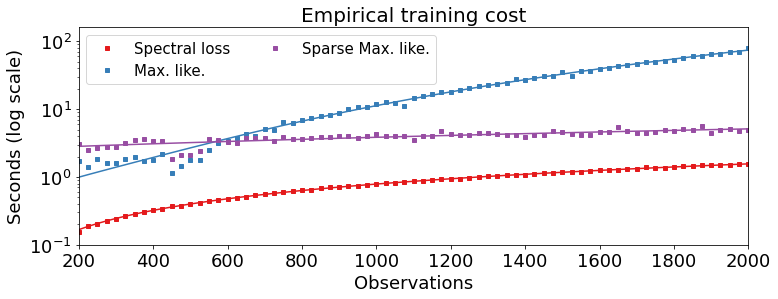

In [6]:
idx = time_stamps != 0
z_w = np.polyfit(indices[idx[0,:]], time_stamps[0,idx[0,:]], 1)
p_w = np.poly1d(z_w)

z_exact = np.polyfit(indices[idx[1,:]], time_stamps[1,idx[1,:]], 3)
p_exact = np.poly1d(z_exact)

z_titsias = np.polyfit(indices[idx[2,:]], time_stamps[2,idx[2,:]], 1)
p_titsias = np.poly1d(z_titsias)


c = plt.cm.Set1
fig = plt.figure(figsize=(12,4))
fig.patch.set_facecolor('white')
plt.plot(indices[idx[0,:]], time_stamps[0,idx[0,:]],'s',ms=4, c = c(0),label='Spectral loss')
plt.plot(indices, p_w(indices),c = c(0))
plt.plot(indices[idx[1,:]], time_stamps[1,idx[1,:]],'s', c = c(1),ms=4,label='Max. like.')
plt.plot(indices, p_exact(indices),c = c(1))
plt.plot(indices[idx[2,:]], time_stamps[2,idx[2,:]],'s', c = c(3),ms=4,label='Sparse Max. like.')
plt.plot(indices, p_titsias(indices),c = c(3))

plt.title('Empirical training cost',fontsize=20)
plt.xlabel('Observations',fontsize=18)
plt.ylabel('Seconds (log scale)',fontsize=18)

plt.legend(fontsize=15, ncol=2)
plt.xlim([200,2000])
plt.yscale('log')
plt.ylim([0.1,160]);
#plt.ylim([1,2]);
plt.savefig('exp2.pdf', bbox_inches='tight')